# Coursework Template

**Dependencies and imports**

This can take a minute...

In [5]:
# !pip install swig
# !pip install --upgrade rldurham

In [6]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from collections import deque
import copy

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=400):
        super(ActorCritic, self).__init__()
        
        # Shared feature extractor with layer normalization
        self.feature_extractor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Tanh()
        )
        
        # Separate policy and value networks to prevent interference
        self.policy_network = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.Tanh()
        )
        
        self.value_network = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.Tanh()
        )
        
        # Policy head with careful initialization
        self.policy_mean = nn.Linear(hidden_size // 2, num_outputs)
        torch.nn.init.uniform_(self.policy_mean.weight, -1e-3, 1e-3)
        torch.nn.init.uniform_(self.policy_mean.bias, -1e-3, 1e-3)
        
        self.value = nn.Linear(hidden_size // 2, 1)

    def forward(self, state):
        features = self.feature_extractor(state)
        policy_features = self.policy_network(features)
        value_features = self.value_network(features)
        
        # Use tanh to bound actions to [-1, 1]
        action_mean = torch.tanh(self.policy_mean(policy_features))
        state_value = self.value(value_features)
        
        return action_mean, state_value

class PPOAgent:
    def __init__(self, num_inputs, num_outputs, hidden_size=400, lr=2e-4, 
                 gamma=0.99, epsilon=0.2, value_coef=0.5, entropy_coef=0.01):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_outputs = num_outputs
        
        # Initialize networks
        self.ac_net = ActorCritic(num_inputs, num_outputs, hidden_size).to(self.device)
        # Create target network for stability
        self.target_net = copy.deepcopy(self.ac_net)
        
        # Initialize optimizer with adaptive learning rate
        self.optimizer = optim.Adam(self.ac_net.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
                                                            factor=0.5, patience=100,
                                                            min_lr=1e-5)
        
        # Initialize hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        
        # Conservative action std settings
        self.action_std = 0.5
        self.min_action_std = 0.1
        self.action_std_decay_rate = 0.02  # Slower decay
        self.action_std_decay_freq = 300   # Less frequent decay
        
        # Experience replay with prioritization
        self.data = []
        self.good_experience_buffer = deque(maxlen=1000)  # Store good experiences
        self.trajectory_length = 0
        self.max_trajectory_length = 2048
        
        # Performance tracking
        self.rewards_history = deque(maxlen=200)
        self.episode_count = 0
        self.best_average_reward = float('-inf')
        self.no_improvement_count = 0
        
        # Episode-specific storage
        self.last_action = None
        self.last_log_prob = None
        
        # Policy averaging
        self.policy_alpha = 0.995  # Rate for updating target network
    
    def _soft_update_target_network(self):
        """Soft update target network for stability"""
        for target_param, param in zip(self.target_net.parameters(), self.ac_net.parameters()):
            target_param.data.copy_(
                self.policy_alpha * target_param.data + (1.0 - self.policy_alpha) * param.data
            )
    
    def sample_action(self, state):
        """Sample action with noise reduction over time and target network stability"""
        state = np.array(state, dtype=np.float32)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            # Use target network for more stable action selection
            action_mean, _ = self.target_net(state_tensor)
            
            # Add carefully controlled noise
            std = torch.full_like(action_mean, self.action_std)
            dist = Normal(action_mean, std)
            action = dist.sample()
            
            # Store for training
            log_prob = dist.log_prob(action).sum(dim=-1)
            action_numpy = action.cpu().numpy().squeeze()
            self.last_action = action_numpy
            self.last_log_prob = log_prob.cpu().numpy()
            
            return [float(a) for a in action_numpy]
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition with reward analysis"""
        # Scale reward for stability
        scaled_reward = reward * 0.1
        
        # Store transition
        action_array = np.array(action, dtype=np.float32)
        transition = (state, action_array, self.last_log_prob, scaled_reward, next_state, done)
        self.data.append(transition)
        
        # Store good experiences separately
        if reward > -50:  # This threshold identifies relatively good experiences
            self.good_experience_buffer.append(transition)
        
        self.trajectory_length += 1
    
    def train(self):
        """Train with stability improvements and experience replay"""
        if len(self.data) < 32:
            return 0.0, 0.0
        
        # Combine current data with some good experiences if available
        training_data = self.data.copy()
        if self.good_experience_buffer:
            # Add a sample of good experiences to the training batch
            good_samples = list(self.good_experience_buffer)
            if len(good_samples) > 32:
                # Sample indices instead of directly sampling tuples
                sample_indices = np.random.choice(len(good_samples), 32, replace=False)
                selected_samples = [good_samples[i] for i in sample_indices]
                training_data.extend(selected_samples)
            else:
                training_data.extend(good_samples)
        
        # Convert to tensors
        states = torch.FloatTensor([t[0] for t in training_data]).to(self.device)
        actions = torch.FloatTensor([t[1] for t in training_data]).to(self.device)
        old_log_probs = torch.FloatTensor([t[2] for t in training_data]).to(self.device)
        rewards = torch.FloatTensor([t[3] for t in training_data]).to(self.device)
        next_states = torch.FloatTensor([t[4] for t in training_data]).to(self.device)
        dones = torch.FloatTensor([t[5] for t in training_data]).to(self.device)
        
        # Compute returns and advantages using target network
        with torch.no_grad():
            _, next_values = self.target_net(next_states)
            _, current_values = self.target_net(states)
            next_values = next_values.squeeze()
            current_values = current_values.squeeze()
            
            # GAE calculation
            advantages = torch.zeros_like(rewards)
            gae = 0
            for t in reversed(range(len(rewards))):
                if t == len(rewards) - 1:
                    next_value = next_values[t]
                else:
                    next_value = current_values[t + 1]
                    
                delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - current_values[t]
                gae = delta + self.gamma * 0.95 * (1 - dones[t]) * gae
                advantages[t] = gae
            
            returns = advantages + current_values
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Adaptive batch size
        batch_size = min(256, max(32, len(training_data) // 4))
        num_updates = 8
        
        total_policy_loss = 0
        total_value_loss = 0
        
        # Multiple epochs of training with conservative updates
        for _ in range(num_updates):
            indices = np.random.permutation(len(training_data))
            
            for start in range(0, len(training_data), batch_size):
                end = start + batch_size
                batch_indices = indices[start:end]
                
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                action_means, values = self.ac_net(batch_states)
                dist = Normal(action_means, torch.full_like(action_means, self.action_std))
                new_log_probs = dist.log_prob(batch_actions).sum(dim=-1)
                
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                clipped_ratio = torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon)
                
                policy_loss = -torch.min(ratio * batch_advantages, 
                                       clipped_ratio * batch_advantages).mean()
                value_loss = ((values.squeeze() - batch_returns) ** 2).mean()
                entropy_loss = -dist.entropy().mean()
                
                # Additional stability through action regularization
                action_penalty = 0.1 * (torch.max(torch.abs(action_means)) - 0.9).clamp(min=0)
                
                total_loss = (policy_loss + 
                             self.value_coef * value_loss + 
                             self.entropy_coef * entropy_loss +
                             action_penalty)
                
                self.optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.ac_net.parameters(), 0.5)
                self.optimizer.step()
                
                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
        
        # Soft update target network
        self._soft_update_target_network()
        
        # Clear current trajectory data but keep good experiences
        self.data = []
        self.trajectory_length = 0
        
        # Calculate average losses
        num_batches = max(1, len(training_data) // batch_size)
        total_updates = num_updates * num_batches
        
        if total_updates > 0:
            avg_policy_loss = total_policy_loss / total_updates
            avg_value_loss = total_value_loss / total_updates
        else:
            avg_policy_loss = total_policy_loss
            avg_value_loss = total_value_loss
        
        return avg_policy_loss, avg_value_loss
    
    def reset(self):
        """Reset episode-specific parameters with stability checks"""
        self.last_action = None
        self.last_log_prob = None
        
        if self.trajectory_length >= self.max_trajectory_length:
            self.train()
            self.trajectory_length = 0
    
    def update_stats(self, episode_reward):
        """Update statistics with stability monitoring"""
        self.rewards_history.append(episode_reward)
        self.episode_count += 1
        
        # Calculate current performance
        current_avg = np.mean(list(self.rewards_history)[-20:])
        
        # Update learning rate based on performance
        self.scheduler.step(current_avg)
        
        # Monitor improvement
        if current_avg > self.best_average_reward:
            self.best_average_reward = current_avg
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
        
        # Only decay exploration if we're seeing improvement
        if self.episode_count % self.action_std_decay_freq == 0:
            if current_avg > -100 and self.no_improvement_count < 50:
                self.action_std = max(self.min_action_std, 
                                    self.action_std - self.action_std_decay_rate)
    
    def get_average_reward(self):
        """Get average reward over last 200 episodes"""
        return np.mean(self.rewards_history)

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


/home/billy/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/billy/Github/ReinforcementLearning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


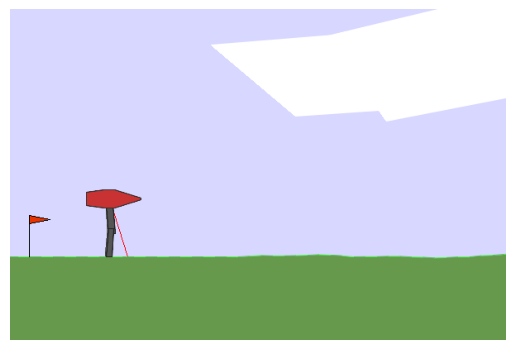

In [8]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

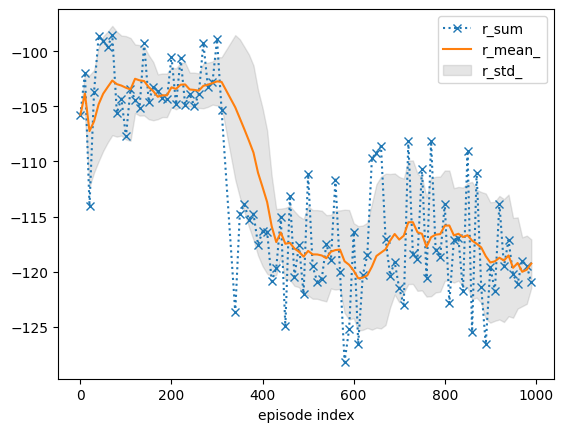

In [9]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = PPOAgent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 1000
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

for episode in range(max_episodes):
    # Set up episode
    env.info = episode % 10 == 0
    env.video = episode % 10 == 0
    current_observation, info = env.reset()
    episode_reward = 0
    
    # Reset agent's temporal smoothing
    agent.reset()
    
    # Run episode
    for t in range(max_timesteps):
        # Get action from agent
        action = agent.sample_action(current_observation)
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition and update episode reward
        agent.put_data(current_observation, action, reward, next_observation, 
                      terminated or truncated)
        episode_reward += reward
        
        # Update observation
        current_observation = next_observation
        
        # Check if episode is done
        if terminated or truncated:
            break
    
    # Train agent and update statistics
    policy_loss, value_loss = agent.train()
    agent.update_stats(episode_reward)
    
    # Print progress every 10 episodes
    if episode % 10 == 0:
        avg_reward = agent.get_average_reward()
        print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
              f"Avg Reward: {avg_reward:.2f}, "
              f"Action STD: {agent.action_std:.3f}")
    
    # Track and plot
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

env.close()

# Write log file
env.write_log(folder="logs", file="xxxx00-agent-log.txt")

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [10]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
